Starting Portfolio Value: 1000.00
2019-09-18, Close, 14.41
2019-09-19, Close, 14.84
2019-09-20, Close, 15.34
2019-09-23, Close, 15.38
2019-09-23, BUY CREATE, 15.38
2019-09-24, BUY EXECUTED, Price: 15.47, Cost: 154.70, Comm 0.00
2019-09-24, Close, 15.18
2019-09-25, Close, 15.75
2019-09-26, Close, 15.71
2019-09-27, Close, 15.90
2019-09-30, Close, 15.59
2019-10-08, Close, 16.20
2019-10-09, Close, 16.25
2019-10-10, Close, 16.24
2019-10-11, Close, 16.81
2019-10-14, Close, 17.22
2019-10-15, Close, 17.18
2019-10-16, Close, 16.79
2019-10-17, Close, 16.70
2019-10-18, Close, 16.51
2019-10-21, Close, 16.89
2019-10-22, Close, 16.42
2019-10-23, Close, 16.45
2019-10-23, SELL CREATE, 16.45
2019-10-24, SELL EXECUTED, Price: 16.50, Cost: 154.70, Comm 0.00
2019-10-24, OPERATION PROFIT, GROSS 10.30, NET 10.30
2019-10-24, Close, 16.87
2019-10-24, BUY CREATE, 16.87
2019-10-25, BUY EXECUTED, Price: 16.78, Cost: 167.80, Comm 0.00
2019-10-25, Close, 16.88
2019-10-28, Close, 16.66
2019-10-28, SELL CREATE, 16.6

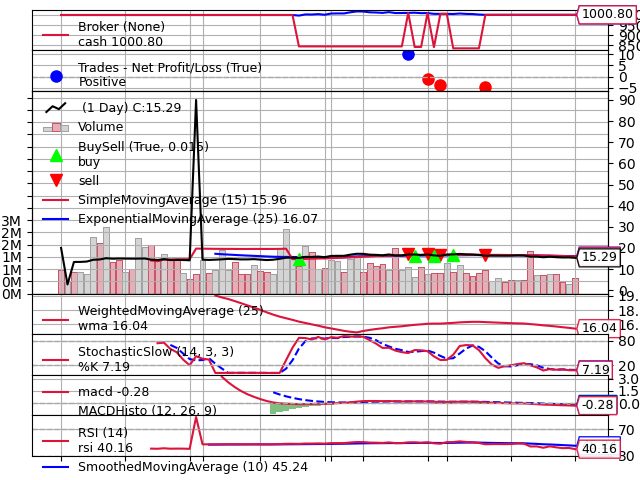

In [3]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
from datetime import datetime
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])
import pandas as pd
# Import the backtrader platform
import backtrader as bt
 
# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)

        # Indicators for the plotting show
        bt.indicators.ExponentialMovingAverage(self.datas[0], period=25)
        bt.indicators.WeightedMovingAverage(self.datas[0], period=25,
                                            subplot=True)
        bt.indicators.StochasticSlow(self.datas[0])
        bt.indicators.MACDHisto(self.datas[0])
        rsi = bt.indicators.RSI(self.datas[0])
        bt.indicators.SmoothedMovingAverage(rsi, period=10)
        bt.indicators.ATR(self.datas[0], plot=False)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] > self.sma[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.dataclose[0] < self.sma[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(TestStrategy)

    stock_hfq_df = pd.read_csv("./sh600000.csv",index_col='date',parse_dates=True)
    
    start_date = datetime(2019, 8, 1)  # 回测开始时间
    end_date = datetime(2023, 1, 30)  # 回测结束时间
    
    data = bt.feeds.PandasData(dataname=stock_hfq_df, fromdate=start_date, todate=end_date)  # 加载数据  
    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(1000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=10)

    # Set the commission
    cerebro.broker.setcommission(commission=0.0)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Plot the result
    # print('python version: ', sys.version)
    %matplotlib widget 
    # cerebro.plot(block=True)
    cerebro.plot(iplot=False)